In [1]:
from scipy.stats import bernoulli, uniform
import numpy as np
import matplotlib.pyplot as plt

In [2]:
T = 100000
num_trials = 10 # we take the average allocations across trials
def run_repeated_fisher_market(n, bid_distribution, adversarial_bid=None):
    """
    adversarial_bid = None means all agents follow bid_distribution when their value is 1.
    Otherwise, agents 1 to n-1 will use adversarial_bid regardless of their value.
    """
    ideal_utility_fractions = []
    for trial in range(num_trials):
        alpha = np.ones(n) / n # symmetric agents
        budgets = T * alpha
        allocations = np.zeros(n)
        for t in range(T):
            values = bernoulli.rvs(alpha) # bernoulli values
            bids = values * bid_distribution()
            if adversarial_bid is not None:
                bids[1:] = adversarial_bid
            bids = np.minimum(budgets, bids) # enforce budget constraint
            if np.any(bids): # check if someone has bid nonzero
                max_bid = np.max(bids)
                winner = np.argmax(bids)
                budgets[winner] -= max_bid
                allocations[winner] += 1
        ideal_utility_fractions.append(allocations[0] / (alpha[0] * T)) # utility of agent 0 / ideal utility
    return ideal_utility_fractions

### The following code takes about 1.5 hours to run

In [3]:
num_agents = list(range(2, 31))
determinstic_bid_allocations = np.array([run_repeated_fisher_market(n, lambda: 2) for n in num_agents])
uniform_bid_allocations = np.array([run_repeated_fisher_market(n, lambda: uniform.rvs(loc=0, scale=1+np.sqrt(2), size=n)) for n in num_agents])

adversarial_bids = [1] #, (1 + (1+np.sqrt(2)))/2, 1+np.sqrt(2)]
uniform_bid_adversarial_bid_allocations_dict = {}
for adversarial_bid in adversarial_bids:
    uniform_bid_adversarial_bid_allocations = np.array([run_repeated_fisher_market(n, lambda: uniform.rvs(loc=0, scale=1+np.sqrt(2), size=n), adversarial_bid=adversarial_bid) for n in num_agents])
    uniform_bid_adversarial_bid_allocations_dict[adversarial_bid] = uniform_bid_adversarial_bid_allocations

In [4]:
determinstic_bid_mean_allocations = np.mean(determinstic_bid_allocations, axis=1)
uniform_bid_mean_allocations = np.mean(uniform_bid_allocations, axis=1)
determinstic_bid_std_allocations = np.std(determinstic_bid_allocations, axis=1, ddof=1)
uniform_bid_std_allocations = np.std(uniform_bid_allocations, axis=1, ddof=1)
determinstic_bid_mean_std_allocations = determinstic_bid_std_allocations / np.sqrt(num_trials)
uniform_bid_mean_std_allocations = uniform_bid_std_allocations / np.sqrt(num_trials)

uniform_bid_adversarial_bid_mean_allocations_dict = {}
uniform_bid_adversarial_bid_mean_std_allocations_dict = {}
for adversarial_bid in adversarial_bids:
    uniform_bid_adversarial_bid_mean_allocations = np.mean(uniform_bid_adversarial_bid_allocations_dict[adversarial_bid], axis=1)
    uniform_bid_adversarial_bid_std_allocations = np.std(uniform_bid_adversarial_bid_allocations_dict[adversarial_bid], axis=1, ddof=1)
    uniform_bid_adversarial_bid_mean_allocations_dict[adversarial_bid] = uniform_bid_adversarial_bid_mean_allocations
    uniform_bid_adversarial_bid_mean_std_allocations_dict[adversarial_bid] = uniform_bid_adversarial_bid_std_allocations / np.sqrt(num_trials)

In [5]:
num_agents = np.array(num_agents)
upper_bound = 1-(1 - 1/num_agents)**num_agents
lower_bound = (2-np.sqrt(2)) * np.ones(len(num_agents))

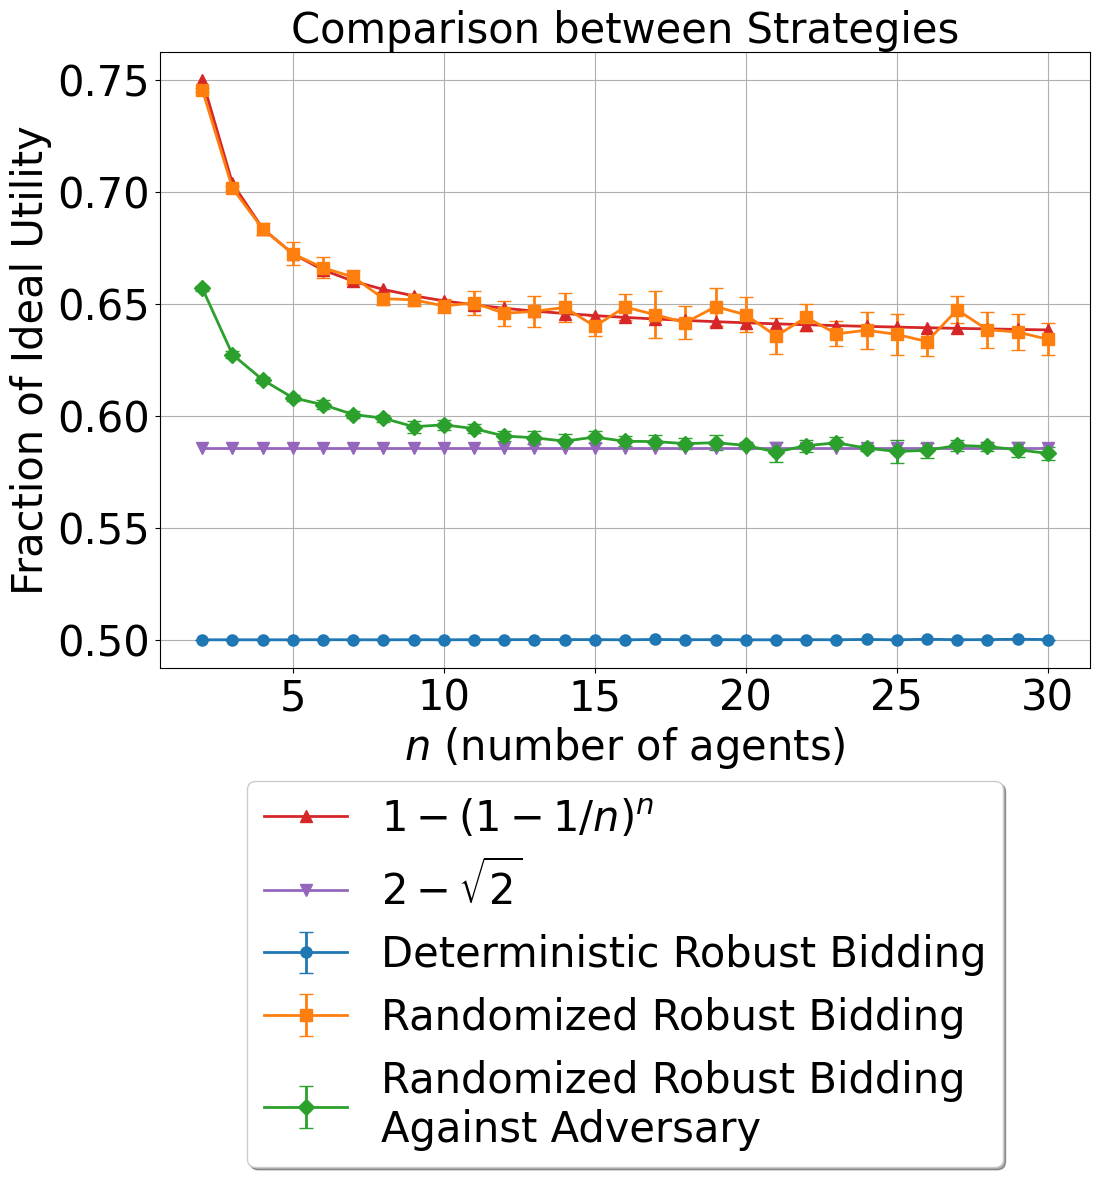

In [29]:
import matplotlib.pyplot as plt
import numpy as np # Added for dummy data generation

# Set global font size - this affects titles, labels, ticks, etc.
plt.rcParams['font.size'] = 30
# You can also set specific rcParams for legend font if preferred
# plt.rcParams['legend.fontsize'] = 18 # Example

plt.figure(figsize=(12, 8))  # Set the figure size

plt.errorbar(
    num_agents,
    determinstic_bid_mean_allocations,
    yerr=2 * determinstic_bid_mean_std_allocations,
    marker='o',
    label='Deterministic Robust Bidding',
    capsize=5,
    linewidth=2, # Slightly thicker line
    markersize=8 # Slightly larger marker
)
plt.errorbar(
    num_agents,
    uniform_bid_mean_allocations,
    yerr=2 * uniform_bid_mean_std_allocations,
    marker='s', # Changed marker for better distinction
    label='Randomized Robust Bidding',
    capsize=5,
    linewidth=2,
    markersize=8
)

# for adversarial_bid in adversarial_bids: # Assuming adversarial_bids was defined elsewhere
for adversarial_bid in [1]:  # Using the provided loop structure
    uniform_bid_adversarial_bid_mean_allocations = uniform_bid_adversarial_bid_mean_allocations_dict[adversarial_bid]
    uniform_bid_adversarial_bid_mean_std_allocations = uniform_bid_adversarial_bid_mean_std_allocations_dict[adversarial_bid]
    plt.errorbar(
        num_agents,
        uniform_bid_adversarial_bid_mean_allocations,
        yerr=2 * uniform_bid_adversarial_bid_mean_std_allocations,
        marker='D', # Changed marker
        label='Randomized Robust Bidding\nAgainst Adversary',
        capsize=5,
        linewidth=2,
        markersize=8
    )

plt.plot(num_agents, upper_bound, label=r'$1 - (1 - 1/n)^n$', linewidth=2, marker='^', markersize=8)
plt.plot(num_agents, lower_bound, label=r'$2-\sqrt{2}$', linewidth=2, marker='v', markersize=8) # Added marker

# Add labels and a title with specified font sizes
plt.xlabel(r'$n$ (number of agents)', fontsize=30) # Slightly increased
plt.ylabel('Fraction of Ideal Utility', fontsize=30) # Slightly increased
plt.title('Comparison between Strategies', fontsize=30) # Slightly increased

# Adjust tick label font size (though rcParams should handle it)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

# Position the legend directly under the graph
# loc='upper center' anchors the top-center of the legend box.
# bbox_to_anchor=(0.5, -0.15) places this anchor at:
#   0.5 (horizontal center of the axes)
#  -0.15 (15% of the axes height *below* the bottom of the axes)
# You might need to tweak the -0.15 value (e.g., -0.1, -0.2) depending on your figure aspect ratio and content.
plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15), # Adjusted y-offset for more space
    ncol=1,
    fontsize=30, # Increased legend font size
    frameon=True, # Optional: adds a frame to the legend
    shadow=True   # Optional: adds a shadow
)

plt.grid(True)  # Add a grid for better readability

# Use plt.tight_layout() BEFORE saving to ensure legend fits
# It adjusts plot parameters to give a tight layout.
# plt.tight_layout(rect=[0, 0.1, 1, 1]) # rect=[left, bottom, right, top] to make space for legend

# Save the figure BEFORE showing it
# bbox_inches='tight' helps to include elements like the legend if they are outside the main axes.
plt.savefig('robust_strategy-comparison-line-bigger.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()